In [1]:
import os
import json
import pickle
import pandas as pd

In [ ]:
!python --version

Python 3.9.16


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CP1/KoBART-summarization

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CP1/KoBART-summarization


## **1. Data Load & Preprocessing**

- 데이터 구성
1.   ★뉴스기사 : 27000
2.   ★보도자료 : 20000
3.   역사_문화재 : 10000
4.   ★보고서 : 10000
5.   회의록 : 34000
6.   ★사설 : 10000
7.   ★간행물 : 10000
8.   연설문 : 40000
9.   문학 : 12000
10.  나레이션 : 10000

#### 자료 개수
- 구어체로 쓰인 나레이션, 연설문, 회의록과, 목적이 다른 문학,역사_문화재를 제외한
뉴스기사, 보도자료, 보고서, 사설, 간행물을 데이터로 활용, 총 1000개 자료

#### 2-3sent
- summary1 : 	1문장 요약(생성요약)
- summary2 : 	2~3문장 요약(추출요약)

#### 20per
- summary1 : 	1문장 요약(생성요약)
- summary3 : 20%요약(추출요약)


- 데이터 링크 https://drive.google.com/file/d/1z6-gbWJtFTJXFQ6-1UafujDfWIfm5uEx/view?usp=sharing
- 데이터 설명서 https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=582

#### **Data concat**

In [ ]:
# 데이터 폴더로 이동
%cd ../
%cd /content/drive/MyDrive/CP1/summary_data

In [ ]:
def json_to_dataframe(directory='/04.paper/20per'): 
  """
  폴더 내의 json 파일을 전부 불러와 하나의 DafaFrame로 합치는 함수

  directory 
  - 기본 /content/drive/MyDrive/CP1/summary_data 
  - 세부로 들어갈때
  """
  path = os.getcwd() + directory
  # path = './[path]' # 데이터가 있는 디렉터리명

  file_list = os.listdir(path)
  # 경로 내에 파일을 모두 불러옴

  json_file_list = [file for file in file_list if file.endswith('.json')]
  #json 확장자를 가진 파일로 새로운 리스트 생성

  # 딕셔너리 형태의 json을 리스트에 더하기
  df = []
  for json_name in json_file_list:
    file_name = path + "/" + json_name
    with open(file_name, 'r') as f: 
      df.append(json.load(f))
  
  df_full = pd.json_normalize(df)

  # 리스트 피클로 저장하기 / save_name 파라미터 필요 
  # save_file = save_name + ".pkl"
  # with open(save_file,"wb") as p:
  #   pickle.dump(df, p)

  return df_full

In [ ]:
def col_rename(df_full):
  """
  DataFrame의 이름을 가독성좋게 바꾸는 함수
  """
  df_full = df_full[['Meta(Acqusition).doc_id','Meta(Acqusition).doc_type','Meta(Acqusition).doc_name','Meta(Refine).passage','Meta(Refine).passage_Cnt','Annotation.summary1']]
  df_full = df_full.rename(columns ={'Meta(Acqusition).doc_id':'doc_id','Meta(Acqusition).doc_type':'doc_type','Meta(Acqusition).doc_name':'doc_name','Meta(Refine).passage':'passage','Meta(Refine).passage_Cnt':'passage_Cnt','Annotation.summary1':'summary'})
  return df_full

In [ ]:
df_news_20per = json_to_dataframe('/01.news_r/20per')
df_news_20per = col_rename(df_news_20per)

df_news_sent = json_to_dataframe('/01.news_r/2~3sent')
df_news_sent = col_rename(df_news_sent)

df_briefing_20per = json_to_dataframe('/02.briefing/20per')
df_briefing_20per = col_rename(df_briefing_20per)

df_briefing_sent = json_to_dataframe('/02.briefing/2~3sent')
df_briefing_sent = col_rename(df_briefing_sent)

df_paper_20per = json_to_dataframe('/04.paper/20per')
df_paper_20per = col_rename(df_paper_20per)

df_paper_sent = json_to_dataframe('/04.paper/2~3sent')
df_paper_sent = col_rename(df_paper_sent)

df_edit_20per = json_to_dataframe('/06.edit/20per')
df_edit_20per = col_rename(df_edit_20per)

df_edit_sent = json_to_dataframe('/06.edit/2~3sent')
df_edit_sent = col_rename(df_edit_sent)

df_public_20per = json_to_dataframe('/07.public/20per')
df_public_20per = col_rename(df_public_20per)

df_public_sent = json_to_dataframe('/07.public/2~3sent')
df_public_sent = col_rename(df_public_sent)

In [ ]:
# 데이터 merge
df = pd.concat([df_news_20per, df_news_sent, df_briefing_20per, df_briefing_sent, 
                df_paper_20per,df_paper_sent, df_edit_20per, df_edit_sent, df_public_20per, df_public_sent], ) #200개
df = df.reset_index()

#### **Data Preprocessing**

In [ ]:
# passage 엔터 제거
df['passage'] = df['passage'].str.replace(pat=r'[\n]',repl=r' ', regex=True)

In [ ]:
df.to_csv('df.csv')

#### **Data 톺아보기** 

In [ ]:
df_paper_20per[:5]

In [ ]:
df_paper_sent[:5]

In [ ]:
df_paper_sent[:5]['summary'][0]

In [ ]:
df['passage'][5]

In [ ]:
df.shape

## **2. Data Split**

In [ ]:
df = pd.read_csv('df.csv', index_col=0)

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
df[df['passage_Cnt'] >= 1024].shape

In [ ]:
df[df['passage_Cnt'] >= 1024].head()

In [ ]:
# 데이터 스플릿
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.85, random_state=42)
train, val = train_test_split(train, train_size=0.8, random_state=42)
train.shape, val.shape, test.shape

In [ ]:
# test 데이터 저장
test.to_csv('test.csv')

## **3. Install Package**

#### **패키지 설치**

In [ ]:
%cd ../
%cd KoBART-summarization

In [ ]:
%mkdir python-3.6.9

In [ ]:
# 파이썬 설치
# 콘다
# conda install python=3.6.9

# 코랩 / 소요시간 5분
%cd python-3.6.9
# !wget https://www.python.org/ftp/python/3.6.9/Python-3.6.9.tgz
!tar xvfz Python-3.6.9.tgz
!Python-3.6.9/configure
!make
!sudo make install
%cd ../

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Compiling '/usr/local/lib/python3.6/encodings/iso8859_3.py'...
Compiling '/usr/local/lib/python3.6/encodings/iso8859_4.py'...
Compiling '/usr/local/lib/python3.6/encodings/iso8859_5.py'...
Compiling '/usr/local/lib/python3.6/encodings/iso8859_6.py'...
Compiling '/usr/local/lib/python3.6/encodings/iso8859_7.py'...
Compiling '/usr/local/lib/python3.6/encodings/iso8859_8.py'...
Compiling '/usr/local/lib/python3.6/encodings/iso8859_9.py'...
Compiling '/usr/local/lib/python3.6/encodings/johab.py'...
Compiling '/usr/local/lib/python3.6/encodings/koi8_r.py'...
Compiling '/usr/local/lib/python3.6/encodings/koi8_t.py'...
Compiling '/usr/local/lib/python3.6/encodings/koi8_u.py'...
Compiling '/usr/local/lib/python3.6/encodings/kz1048.py'...
Compiling '/usr/local/lib/python3.6/encodings/latin_1.py'...
Compiling '/usr/local/lib/python3.6/encodings/mac_arabic.py'...
Compiling '/usr/local/lib/python3.6/encodings/mac_centeuro.py'...
Compiling '/usr/local/lib/python3

-  https://pypi.org/project/torchtext/ torchtext version
- https://pytorch.org/get-started/previous-versions/ other version

In [ ]:
!python --version

Python 3.6.9


In [ ]:
# koBART 코랩환경 / 소요시간 12분, 2분, 10분
!pip install pandas
!pip install torchvision==0.8.2+cu101 torchtext==0.11.0 -f https://download.pytorch.org/whl/torch_stable.html
## ImportError: cannot import name 'get_num_classes' from 'torchmetrics.utilities.data'
!pip install torchmetrics==0.6.0 
!pip install torch==1.10.0
!pip install transformers==4.16.2
!pip install streamlit==1.2.0
## loader 오류 방지
!pip install pyyaml==5.4.1
## pytorch_lightening 설치 돕기 위해
!pip3 install --upgrade pip
!python3 -m pip install --upgrade setuptools
## AttributeError: 'Trainer' object has no attribute '_data_connector'
!pip install pytorch_lightning==1.5.10

# 버전확인 
# !pip show torch
# !pip show torchtext

# torch 패키지 설치

#/usr/local/lib/python3.8/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
# warn(f"Failed to load image Python extension: {e}")
# OSError: /usr/local/lib/python3.8/dist-packages/torchtext/_torchtext.so: undefined symbol
# >> 자신 torch 버전에 맞게 torchtext 재설치 >> https://github.com/pytorch/text#installation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached torchtext-0.11.0-cp36-cp36m-manylinux1_x86_64.whl (8.0 MB)
  Using cached https://download.pytorch.org/whl/rocm3.8/torch-1.7.1%2Brocm3.8-cp36-cp36m-linux_x86_64.whl (588.0 MB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
  Using cached https://download.pytorch.org/whl/cu101/torchvision-0.8.2%2Bcu101-cp36-cp36m-linux_x86_64.whl (12.8 MB)
ERROR: Cannot install torchtext==0.11.0 and torchvision==0.8.2+cu101 because these package versions have conflicting dependencies.

The conflict is caused by:
    torchvision 0.8.2+cu101 depends on torch==1.7.1
    torchtext 0.11.0 depends on torch==1.10.0

To fix this you co

In [ ]:
# 로컬용 패키지 
# !pip install pandas
# !pip install torch==1.9.1
# !pip install torchtext==0.10.1
# !pip install torchvision==0.10.1
# !pip install torchmetrics==0.5.1
# !pip install transformers==4.8.2
# !pip install streamlit==1.1.0
# !pip install pyyaml==5.4.1
# !pip install pytorch_lightning==1.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 831.4 MB 15 kB/s              
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0
    Uninstalling torch-1.10.0:
      Successfully uninstalled torch-1.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 455 kB/s             
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.11.0
    Uninstalling torchtext-0.11.0:
      Successfully uninstalle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 282 kB 26.7 MB/s            
  Attempting uninstall: torchmetrics
    Found existing installation: torchmetrics 0.6.0
    Uninstalling torchmetrics-0.6.0:
      Successfully uninstalled torchmetrics-0.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.8.2-py3-none-any.whl (2.5 MB)
  Using cached huggingface_hub-0.0.12-py3-none-any.whl (37 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.4.0
    Uninstalling huggingface-hub-0.4.0:
      Successfully uninstalled huggingface-hub-0.4.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.16.2
    Uninstalling transformers-4.16.2:
      Successfully uninstalled transformers-4.16.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd ../

In [ ]:
# 패키지 설치 / KoBART # 총2분 
# 학습용
# !git clone https://github.com/seujung/KoBART-summarization.git

## **4. Train Data**

#### **Unzip & Merge Data to train/test file**

In [ ]:
%cd KoBART-summarization/data

# train, test 압축 해제
!tar -zxvf train.tar.gz
!tar -zxvf test.tar.gz

# 파일 내용 확인
# !cat train.tsv
# !cat test.tsv

%cd ../

In [ ]:
# 데이터 Merge
train[['passage','summary']].to_csv("/content/drive/MyDrive/CP1/KoBART-summarization/data/train.tsv", mode='a', header=0, sep='\t', index=False)
val[['passage','summary']].to_csv("/content/drive/MyDrive/CP1/KoBART-summarization/data/test.tsv", mode='a', header=0, sep='\t', index=False)

#### **Train Model**
- 클릭 절대 주의

In [ ]:
# 코랩 끊김방지 코드 
function ClickConnect(){
    console.log("코랩 연결 끊김 방지"); 
    document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect, 60 * 5000)

In [ ]:
# 데이터 학습
!python train.py  --gradient_clip_val 1.0 --max_epochs 5 --default_root_dir logs  --gpus 1 --batch_size 4 --num_workers 4

# 데이터학습1 에포크 1 
# 데이터학습2 에포크 3 총 소요시간 2시간 30분
# 데이터학습3 에포크 3 총 소요시간 5시간 40분
# 데이터학습4 에포크 5 총 소요시간 8시간 40분 

# 위치 /content/drive/MyDrive/CP1/KoBART-summarization
# 생성파일 /content/drive/MyDrive/CP1/KoBART-summarization/logs/model_chp/epoch=00-val_loss=1.368.ckpt

Downloading: 100% 4.00/4.00 [00:00<00:00, 3.77kB/s]
Downloading: 100% 111/111 [00:00<00:00, 47.6kB/s]
Downloading: 100% 682k/682k [00:00<00:00, 4.39MB/s]
INFO:root:Namespace(accelerator=None, accumulate_grad_batches=None, amp_backend='native', amp_level=None, auto_lr_find=False, auto_scale_batch_size=False, auto_select_gpus=False, batch_size=4, benchmark=False, check_val_every_n_epoch=1, checkpoint_callback=None, checkpoint_path=None, default_root_dir='logs', detect_anomaly=False, deterministic=False, devices=None, enable_checkpointing=True, enable_model_summary=True, enable_progress_bar=True, fast_dev_run=False, flush_logs_every_n_steps=None, gpus=1, gradient_clip_algorithm=None, gradient_clip_val=1.0, ipus=None, limit_predict_batches=1.0, limit_test_batches=1.0, limit_train_batches=1.0, limit_val_batches=1.0, log_every_n_steps=50, log_gpu_memory=None, logger=True, lr=3e-05, max_epochs=5, max_len=512, max_steps=-1, max_time=None, min_epochs=None, min_steps=None, model_path=None, move_

#### **Save Model**

- 대용량 파일(1G 이하) 업로드 https://syki66.github.io/blog/2020/08/17/git-lfs.html

In [ ]:
# 학습한 체크포인트 불러오기
# 저장위치 kobart_summary 폴더
# OES 발생 시 다시 한번 torch 패키지 설치(미작동되는 경우 있음)

# !python get_model_binary.py --hparams ./logs/tb_logs/default/version_0/hparams.yaml --model_binary ./logs/model_chp/epoch=50-val_loss=1.464.ckpt
# !python get_model_binary.py --hparams ./logs/tb_logs/default/version_0/hparams.yaml --model_binary $(ls -1 -t ./logs/model_chp | head -1)

!python get_model_binary.py --hparams ./logs/tb_logs/default/version_3/hparams.yaml --model_binary ./logs/model_chp/epoch=00-val_loss=1.336.ckpt --output_dir ./kobart_summary/models/model6-version3-ep00-1.336
!python get_model_binary.py --hparams ./logs/tb_logs/default/version_3/hparams.yaml --model_binary ./logs/model_chp/epoch=01-val_loss=1.322.ckpt --output_dir ./kobart_summary/models/model7-version3-ep01-1.322
!python get_model_binary.py --hparams ./logs/tb_logs/default/version_3/hparams.yaml --model_binary ./logs/model_chp/epoch=02-val_loss=1.350.ckpt --output_dir ./kobart_summary/models/model8-version3-ep02-1.350
!python get_model_binary.py --hparams ./logs/tb_logs/default/version_3/hparams.yaml --model_binary ./logs/last.ckpt --output_dir ./kobart_summary/models/model9-version3-ep04

get_model_binary.py:13: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  hparams = yaml.load(f)
Downloading: 100% 1.36k/1.36k [00:00<00:00, 1.32MB/s]
Downloading: 100% 496M/496M [00:10<00:00, 49.3MB/s]
Downloading: 100% 4.00/4.00 [00:00<00:00, 2.63kB/s]
Downloading: 100% 111/111 [00:00<00:00, 75.2kB/s]
Downloading: 100% 682k/682k [00:01<00:00, 600kB/s]
get_model_binary.py:13: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  hparams = yaml.load(f)
get_model_binary.py:13: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  hparams = yaml.load(f)
get_model_binary.py:13: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the defaul

In [ ]:
# KoBART / SKT-AI
# !pip install git+https://github.com/SKT-AI/KoBART#egg=kobart

#### **Apply & Get the result**

In [ ]:
# test 파일 불러오기
test = pd.read_csv('test.csv', index_col=0)
test.describe()

,index,passage_Cnt
count,150.000000,150.000000
mean,49.840000,835.200000
std,29.011935,200.721651
min,0.000000,518.000000
25%,23.250000,721.000000
50%,47.500000,758.000000
75%,75.750000,854.000000
max,99.000000,1372.000000


In [ ]:
import torch
from transformers import PreTrainedTokenizerFast
from transformers import BartForConditionalGeneration

In [ ]:
def test_model(df, model, tokenizer):
  """
  dataset의 text를 model과 tokenizer에 맞춰 summarize 하는 함수
  출력 : list
  """
  lst_summary = []
  for index in list(df.index):
    print(index, end=' ') #현재 진행위치 기록용 
    text = df.loc[index, 'passage']
    raw_input_ids = tokenizer.encode(text)
    input_ids = [tokenizer.bos_token_id] + raw_input_ids + [tokenizer.eos_token_id]

    summary_ids = model.generate(torch.tensor([input_ids]),  num_beams=4,  max_length=128,  eos_token_id=1)
    summary = tokenizer.decode(summary_ids.squeeze().tolist(), skip_special_tokens=True)
    lst_summary.append((index, text, summary))

  return lst_summary

In [ ]:
def save_result(model_path='./kobart_summary/', tokenizer_path='gogamza/kobart-summarization', file_name='my.csv'):
  """
  test_model(model을 dataset에 적용하여 요약문을 포함한 list 생성) 후 결과를 csv파일로 저장하는 함수
  """
  model = BartForConditionalGeneration.from_pretrained(model_path)
  tokenizer = PreTrainedTokenizerFast.from_pretrained(tokenizer_path)

  summary = test_model(test, model, tokenizer)

  print(summary[0])

  df = pd.DataFrame(summary, columns=['index','text','summary'])
  df['label'] = test['summary']
  df.to_csv(file_name, encoding='utf-8')

In [ ]:
# model - 직접 학습 / 7분 
# tokenizer - gogamza/kobart-summarization
# 소요시간 약 20분 (개당 3~5초)

save_result(model_path='./kobart_summary/models/model6-version3-ep00-1.336', file_name='./result/ver3-ep00.csv')
save_result(model_path='./kobart_summary/models/model7-version3-ep01-1.322', file_name='./result/ver3-ep01.csv')
save_result(model_path='./kobart_summary/models/model8-version3-ep02-1.350', file_name='./result/ver3-ep02.csv')
save_result(model_path='./kobart_summary/models/model9-version3-ep04', file_name='./result/ver3-ep04.csv')

In [ ]:
# model - pretrained 
# tokenizer - gogamza/kobart-summarization
## premodel 사용 시 결과 비교 
save_result(model_path='gogamza/kobart-summarization', tokenizer_path='gogamza/kobart-summarization', file_name='pre_kobart.csv')

In [ ]:
save_result(model_path='google/pegasus-xsum', tokenizer_path='google/pegasus-xsum', file_name='pre_pegasus_xsum.csv')

NameError: ignored

## **5. Evaluate Model**

In [4]:
label = pd.read_csv('label.csv', encoding='utf-8')
pre_kobart = pd.read_csv('./result/pre_kobart.csv', encoding='utf-8')
ver1_ep00 = pd.read_csv('./result/ver1-ep00.csv', encoding='utf-8')
ver1_ep01 = pd.read_csv('./result/ver1-ep01.csv', encoding='utf-8')
ver2_ep00 = pd.read_csv('./result/ver2-ep00.csv', encoding='utf-8')
ver2_ep01 = pd.read_csv('./result/ver2-ep01.csv', encoding='utf-8')
ver2_ep02 = pd.read_csv('./result/ver2-ep02.csv', encoding='utf-8')
ver3_ep00 = pd.read_csv('./result/ver3-ep00.csv', encoding='utf-8')
ver3_ep01 = pd.read_csv('./result/ver3-ep01.csv', encoding='utf-8')
ver3_ep02 = pd.read_csv('./result/ver3-ep02.csv', encoding='utf-8')
ver3_ep04 = pd.read_csv('./result/ver3-ep04.csv', encoding='utf-8')

label.shape, pre_kobart.shape, ver1_ep00.shape, ver3_ep04.shape

((150, 2), (150, 4), (150, 4), (150, 5))

#### **Rouge Score**

In [5]:
# rouge score 
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from rouge import Rouge 

def score_to_dataframe(df):
  df = pd.json_normalize(df)
  return df

def scores_rouge(df):
  rouge = Rouge()

  hyps = df['summary'].tolist()
  refs = label['summary'].tolist()

  scores = rouge.get_scores(hyps, refs, avg=True)
  scores = score_to_dataframe(scores)

  return scores

In [7]:
# rouge score 

scores_pre_kobart = scores_rouge(pre_kobart)
scores_ver1_ep00 = scores_rouge(ver1_ep00)
scores_ver1_ep01 = scores_rouge(ver1_ep01)
scores_ver2_ep00 = scores_rouge(ver2_ep00)
scores_ver2_ep01 = scores_rouge(ver2_ep01)
scores_ver2_ep02 = scores_rouge(ver2_ep02)
scores_ver3_ep00 = scores_rouge(ver3_ep00)
scores_ver3_ep01 = scores_rouge(ver3_ep01)
scores_ver3_ep02 = scores_rouge(ver3_ep02)
scores_ver3_ep04 = scores_rouge(ver3_ep04)

In [ ]:
pd.set_option('display.max_columns', 10)

In [8]:
df_list = [scores_pre_kobart, scores_ver1_ep00, scores_ver1_ep01, scores_ver2_ep00, scores_ver2_ep01, scores_ver2_ep02, scores_ver3_ep00, scores_ver3_ep01, scores_ver3_ep02, scores_ver3_ep04]
scores = pd.concat(df_list, axis=0)
scores.index = ['pre_kobart', 'ver1_ep00', 'ver1_ep01', 'ver2_ep00', 'ver2_ep01', 'ver2_ep02', 'ver3_ep00', 'ver3_ep01', 'ver3_ep02', 'ver3_ep04']
scores_sort = scores.sort_values('rouge-1.f', ascending=False)
scores_sort

,rouge-1.r,rouge-1.p,rouge-1.f,rouge-2.r,rouge-2.p,rouge-2.f,rouge-l.r,rouge-l.p,rouge-l.f
ver3_ep01,0.278939,0.243889,0.248709,0.171361,0.152796,0.154013,0.264139,0.233647,0.237542
pre_kobart,0.291922,0.225520,0.242682,0.165220,0.127052,0.136710,0.274837,0.213485,0.229109
ver3_ep04,0.267703,0.227176,0.237330,0.161060,0.140094,0.144543,0.255221,0.217166,0.226870
ver2_ep02,0.272115,0.221613,0.236224,0.158464,0.128182,0.136336,0.260157,0.211892,0.225839
ver1_ep01,0.257171,0.230586,0.234528,0.153066,0.138707,0.140587,0.248314,0.223635,0.227088
ver2_ep01,0.257171,0.230586,0.234528,0.153066,0.138707,0.140587,0.248314,0.223635,0.227088
ver3_ep02,0.276691,0.219638,0.233584,0.161139,0.127066,0.135233,0.261371,0.208525,0.221515
ver3_ep00,0.255079,0.227734,0.231382,0.151883,0.137343,0.138963,0.240520,0.217122,0.219812
ver2_ep00,0.260940,0.222285,0.230514,0.151967,0.134496,0.136380,0.247631,0.212613,0.219696
ver1_ep00,0.232834,0.194826,0.204262,0.135182,0.116259,0.119740,0.220023,0.186429,0.194422


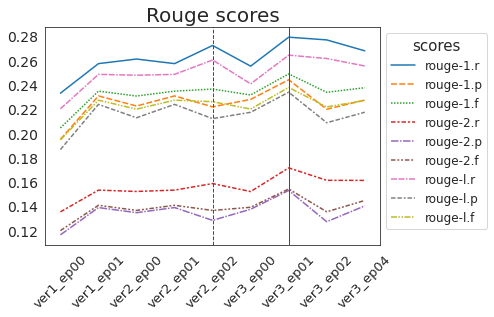

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')

plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=14)
graph = sns.lineplot(scores[1:])
plt.title('Rouge scores', fontsize=20)
plt.legend(title='scores', title_fontsize=15)
plt.axvline(x='ver3_ep01', color='green',linewidth=1, linestyle='-')
plt.axvline(x='ver2_ep02', color='green',linewidth=1, linestyle='--')
sns.move_legend(graph, "upper left", bbox_to_anchor=(1, 1), fontsize=12)
plt.show()

In [21]:
scores[['rouge-1.f','rouge-2.f','rouge-l.f']]

,rouge-1.f,rouge-2.f,rouge-l.f
pre_kobart,0.242682,0.136710,0.229109
ver1_ep00,0.204262,0.119740,0.194422
ver1_ep01,0.234528,0.140587,0.227088
ver2_ep00,0.230514,0.136380,0.219696
ver2_ep01,0.234528,0.140587,0.227088
ver2_ep02,0.236224,0.136336,0.225839
ver3_ep00,0.231382,0.138963,0.219812
ver3_ep01,0.248709,0.154013,0.237542
ver3_ep02,0.233584,0.135233,0.221515
ver3_ep04,0.237330,0.144543,0.226870


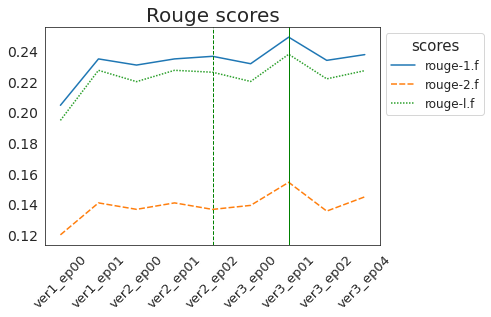

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')

plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=14)
graph = sns.lineplot(scores[['rouge-1.f','rouge-2.f','rouge-l.f']][1: ])
plt.title('Rouge scores', fontsize=20)
plt.legend(title='scores', title_fontsize=15)
plt.axvline(x='ver3_ep01', color='green',linewidth=1, linestyle='-')
plt.axvline(x='ver2_ep02', color='green',linewidth=1, linestyle='--')
sns.move_legend(graph, "upper left", bbox_to_anchor=(1, 1), fontsize=12)
plt.show()

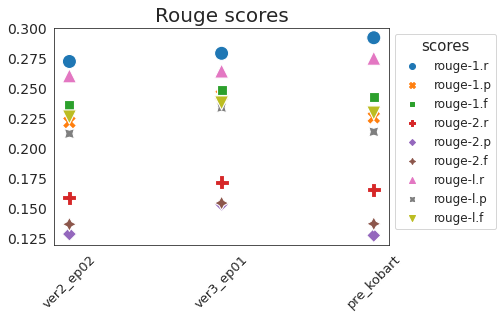

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')

plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=14)
# plt.axis([-1, 2.1, 0.11, 0.32])
graph = sns.scatterplot(scores.loc[['ver2_ep02','ver3_ep01','pre_kobart'],:], s=200)
plt.title('Rouge scores', fontsize=20)
plt.legend(title='scores', title_fontsize=15)
sns.move_legend(graph, "upper left", bbox_to_anchor=(1, 1), fontsize=12)
plt.show()

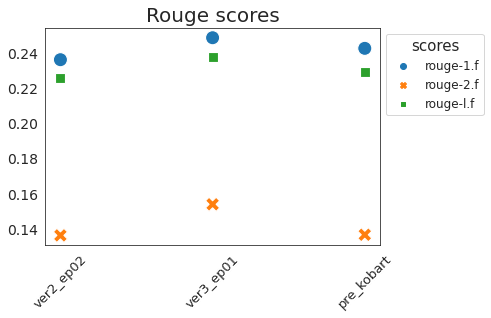

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')

plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=14)
# plt.axis([-1, 2.1, 0.11, 0.32])
graph = sns.scatterplot(scores.loc[['ver2_ep02','ver3_ep01','pre_kobart'],['rouge-1.f','rouge-2.f','rouge-l.f']], s=200)
plt.title('Rouge scores', fontsize=20)
plt.legend(title='scores', title_fontsize=15)
sns.move_legend(graph, "upper left", bbox_to_anchor=(1, 1), fontsize=12)
plt.show()

# 정밀도는 참조 요약과 일치하는 시스템 생성 요약의 백분율을 측정합니다. 시스템에서 생성된 요약과 참조 요약 간의 중복 단어 수를 시스템에서 생성된 요약의 총 단어 수로 나눈 값으로 계산됩니다.
# 리콜은 시스템에서 생성된 요약에 포함된 참조 요약의 백분율을 측정합니다. 시스템에서 생성된 요약과 참조 요약 사이의 중복 단어 수를 참조 요약의 총 단어 수로 나눈 값으로 계산됩니다

#### **RDASS Score**

- RDASS 논문 원문 https://arxiv.org/pdf/2005.03510v2.pdf
- RDASS 소개 https://kakaoenterprise.github.io/deepdive/210729

In [3]:
!pip install sentence-transformers
!pip install numpy
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 116.1 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=194dc5788702c1c271661fe9163b6ec097a76b2185dc02f968f02d3b703df48a
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

In [ ]:
# 데이터 불러오기
label = pd.read_csv('label.csv', encoding='utf-8')
pre_kobart = pd.read_csv('./result/pre_kobart.csv', encoding='utf-8')
ver1_ep00 = pd.read_csv('./result/ver1-ep00.csv', encoding='utf-8')
ver1_ep01 = pd.read_csv('./result/ver1-ep01.csv', encoding='utf-8')
ver2_ep00 = pd.read_csv('./result/ver2-ep00.csv', encoding='utf-8')
ver2_ep01 = pd.read_csv('./result/ver2-ep01.csv', encoding='utf-8')
ver2_ep02 = pd.read_csv('./result/ver2-ep02.csv', encoding='utf-8')
ver3_ep00 = pd.read_csv('./result/ver3-ep00.csv', encoding='utf-8')
ver3_ep01 = pd.read_csv('./result/ver3-ep01.csv', encoding='utf-8')
ver3_ep02 = pd.read_csv('./result/ver3-ep02.csv', encoding='utf-8')
ver3_ep04 = pd.read_csv('./result/ver3-ep04.csv', encoding='utf-8')

In [36]:
def RDASS(sentences):
  """
  입력값 = 리스트(문서, 정답, 모델생성문장)
  sentences = ['This is a sentence.', 'This is another sentence.', 'I am writing a sample sentence.']
  """
  # SBERT 모델 로드
  sbert_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

  doc = sentences['doc']
  label = sentences['label']
  summary = sentences['summary']

  # SBERT로 임베딩 생성
  d_emb = sbert_model.encode([doc])
  r_emb = sbert_model.encode([label])
  p_emb = sbert_model.encode([summary])

  # 코사인 유사도 계산
  dp_cos_sim = np.inner(d_emb, p_emb)[0][0]
  rp_cos_sim = np.inner(r_emb, p_emb)[0][0]

  # 결과 출력
  return (dp_cos_sim+rp_cos_sim)/2

In [37]:
def save_rdass(df, file_path='./result/RDASS/',file_name='rdass_ver0-ep00'):
  """
  RDASS 함수를 적용하여 각 데이터의 코사인유사도를 구하고 저장하는 함수
  """
  # 함수 input에 맞게 형태 가공
  df_rdass = pd.DataFrame([df['text'], label['summary'], df['summary']]).T
  df_rdass.columns = ['doc','label','summary']

  # 함수 적용
  df_rdass['RDASS'] = df_rdass.apply(RDASS, axis=1)

  # 점수 csv 파일로 저장
  file = file_path + file_name+'.csv'
  df_rdass.to_csv(file, encoding='utf-8')
  return df_rdass['RDASS'].mean()

In [57]:
# RDASS 스코어 구하기
## 총 56분 / 각 6분
score_pre_kobart = save_rdass(pre_kobart, file_name='rdass_pre_kobart')
score_ver1_ep00 = save_rdass(ver1_ep00, file_name='rdass_ver1_ep00')
score_ver1_ep01 = save_rdass(ver1_ep01, file_name='rdass_ver1_ep01')
score_ver2_ep00 = save_rdass(ver2_ep00, file_name='rdass_ver2_ep00')
score_ver2_ep01 = save_rdass(ver2_ep01, file_name='rdass_ver2_ep01')
score_ver2_ep02 = save_rdass(ver2_ep02, file_name='rdass_ver2_ep02')
score_ver3_ep00 = save_rdass(ver3_ep00, file_name='rdass_ver3_ep00')
score_ver3_ep01 = save_rdass(ver3_ep01, file_name='rdass_ver3_ep01')
score_ver3_ep02 = save_rdass(ver3_ep02, file_name='rdass_ver3_ep02')
score_ver3_ep04 = save_rdass(ver3_ep04, file_name='rdass_ver3_ep04')

In [52]:
def cosine_similarity(sentences):
  """
  입력값 = 문서, 정답
  """
  # SBERT 모델 로드
  sbert_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

  doc = sentences['text']
  label = sentences['summary']

  # SBERT로 임베딩 생성
  d_emb = sbert_model.encode([doc])
  r_emb = sbert_model.encode([label])

  # 코사인 유사도 계산
  dr_cos_sim = np.inner(d_emb, r_emb)[0][0]

  # 결과 출력
  return dr_cos_sim

In [ ]:
# 정답과 문서의 코사인 유사도 구하기
df_label = pd.DataFrame([ver1_ep00['text'], label['summary']]).T
df_label['cosine_similarity'] = df_label.apply(cosine_similarity, axis=1)
df_label.to_csv('./result/RDASS/cosine_label.csv', encoding='utf-8')

In [42]:
# 코사인 유사도 및 RDASS 결과 불러오기
df_label = pd.read_csv('./result/RDASS/cosine_label.csv')
df_pre_kobart = pd.read_csv('./result/RDASS/rdass_pre_kobart.csv')

In [85]:
score_rdass = score_ver1_ep00, score_ver1_ep01, score_ver2_ep00, score_ver2_ep01, score_ver2_ep02, score_ver3_ep00, score_ver3_ep01, score_ver3_ep02, score_ver3_ep04
score_rdass_label = df_label['cosine_similarity'].mean()

In [43]:
score_pre_kobart = df_pre_kobart['RDASS'].mean()
score_rdass_label = df_label['cosine_similarity'].mean()

score_rdass = (6.40252676486969, 6.439966268539429, 6.572686915397644,
 6.439966268539429, 6.600648280779521, 6.47744421005249, 6.452836793263753, 6.484066516558329, 6.392950928211212)

<ipython-input-49-3ba8e1f25169>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph.set_xticklabels(['pre_kobart', 'ver1_ep00', 'ver1_ep01', 'ver2_ep00', 'ver2_ep01', 'ver2_ep02', 'ver3_ep00', 'ver3_ep01', 'ver3_ep02', 'ver3_ep04'], fontsize=12)


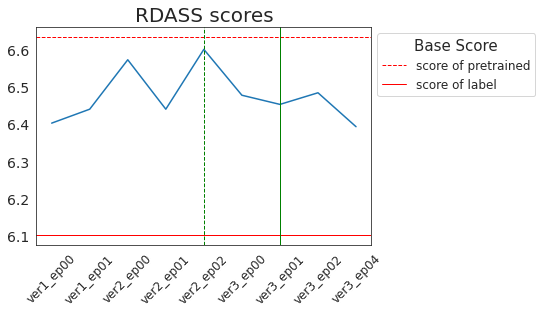

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')

plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=14)
graph = sns.lineplot(score_rdass)
plt.title('RDASS scores', fontsize=20)
graph.set_xticklabels(['pre_kobart', 'ver1_ep00', 'ver1_ep01', 'ver2_ep00', 'ver2_ep01', 'ver2_ep02', 'ver3_ep00', 'ver3_ep01', 'ver3_ep02', 'ver3_ep04'], fontsize=12)
plt.axhline(y=score_pre_kobart, color='red',linewidth=1, linestyle='--', label='score of pretrained')
plt.axhline(y=score_rdass_label, color='red',linewidth=1, label='score of label')
plt.axvline(x=6, color='green',linewidth=1, linestyle='-')
plt.axvline(x=4, color='green',linewidth=1, linestyle='--')
plt.legend(title='Base Score', title_fontsize=15)
sns.move_legend(graph, "upper left", bbox_to_anchor=(1, 1), fontsize=12)
plt.show()